The goal of this excercise is to split data automatically into two parts, after a change in trend, assuming those are count related data from Poisson distributions with different lambdas. This excercise is not original and follows the concepts of book Probabilistic-Programming-and-Bayesian-Methods-for-Hackers and PYMC tutorial https://pymc-devs.github.io/pymc/tutorial.html#

In [2]:
import numpy as np
import pymc3 as pm

from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

%matplotlib inline

plt.style.use('bmh')
colours = ['#bd345d', '#7a68a6', '#467821']

We will generate data from Poisson probability distributions with two different lambda paramaters. We will draw lambda from exponential distribution and threshold from discrete uniform disctribution. 

In [11]:
#specify params of your data
total_observations = 100
lambda_exp = 0.25

lam_1 = np.random.exponential(1/lambda_exp)
lam_2 = np.random.exponential(1/lambda_exp)
threshold = np.random.random_integers(0.25*total_observations, 0.75*total_observations)

print(lam_1, lam_2, tau)

arr_1 = np.random.poisson(lam=lam_1, size=tau)
arr_2 = np.random.poisson(lam=lam_2, size=total_observations-tau)
arr = np.concatenate((arr_1, arr_2))
n_arr = total_observations
av = 1.0/np.average(arr)

4.712864300458678 7.716266724665642 38


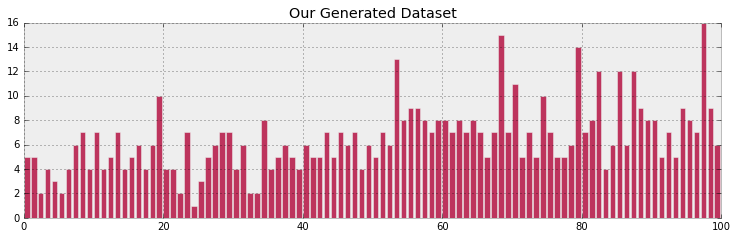

In [12]:
figsize(12.5, 3.5)
plt.bar(np.arange(n_arr), arr, color=colours[0])
plt.title("Our Generated Dataset");

All the variables we model should belong to the Model object.

We will assume that lambda's are drawn from exponential distribution and the threshold tau is initially drawn from a Discrete Uniform distribution.

In [13]:
with pm.Model() as model:
    # create lambda_1 and lambda_2 as stochastic variables
    # (random number generators)
    lambda_1 = pm.Exponential("lambda_1", 1/av)
    lambda_2 = pm.Exponential("lambda_2", 1/av)
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_arr)

In [14]:
with model:
    idx = np.arange(n_arr)
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)
    
with model:
    observation = pm.Poisson("obs", lambda_, observed=arr)

In [15]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(1000, tune=500, step=step)
    
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

100%|██████████| 1000/1000 [00:00<00:00, 3332.05it/s]


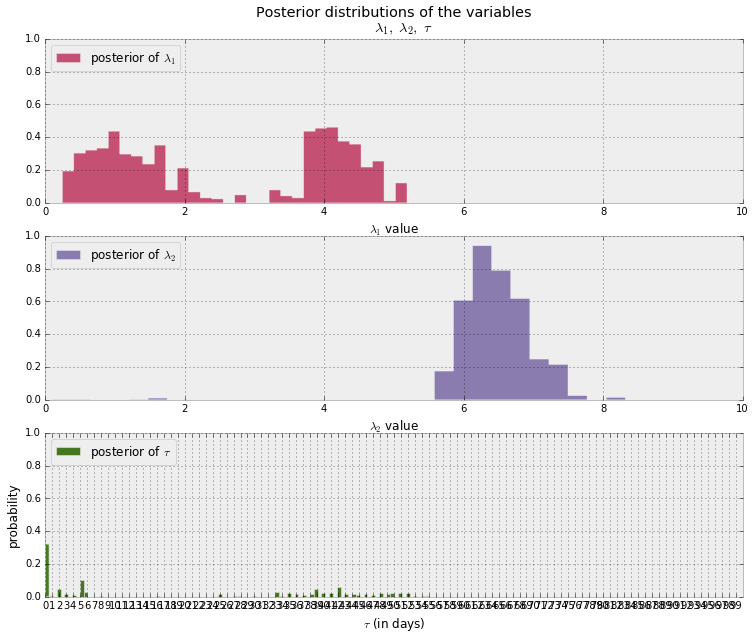

In [16]:
figsize(12.5, 10)
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(
    lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
    label="posterior of $\lambda_1$", color=colours[0], normed=True,
)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim(0,10)
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(
    lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
    label="posterior of $\lambda_2$", color=colours[1], normed=True,
)
plt.legend(loc="upper left")
plt.xlim(0,10)
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_arr, alpha=1,
         label=r"posterior of $\tau$",
         color=colours[2], weights=w, rwidth=2.)
plt.xticks(np.arange(n_arr))

plt.legend(loc="upper left")
plt.ylim([0, 1])
plt.xlim([0, n_arr])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");